# Large Scale Pretrained Audio Neural Networks Autoencoder for DCASE‑Inspired Anomalous Sound Detection


In [1]:
# Install dependencies if needed
# !pip install torch torchvision torchaudio librosa tqdm scikit-learn

In [2]:
import os, glob, random, numpy as np
import torch
import torchaudio
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from tqdm import tqdm


## Data Prep & PANN Embedding Extraction

In [3]:
TRAIN_WAV = 'DATA/dev_data/dev_data/slider/train'
TEST_WAV  = 'DATA/dev_data/dev_data/slider/test'
EMB_DIR   = 'DATA/embeddings_panns'
os.makedirs(f'{EMB_DIR}/train', exist_ok=True)
os.makedirs(f'{EMB_DIR}/test',  exist_ok=True)

# Import PANNs Inference API
from panns_inference import AudioTagging

# Initialize AudioTagging (uses pretrained CNN14_16k under the hood)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
at = AudioTagging(checkpoint_path=None, device=DEVICE)

# Function to extract and save embeddings from PANNs
import torchaudio.functional as Ffunc

def extract_save(wav_list, split):
    out_dir = os.path.join(EMB_DIR, split)
    for wav in tqdm(wav_list, desc=f'Extract {split}', leave=False):
        name = os.path.basename(wav).replace('.wav', '.npy')
        out_path = os.path.join(out_dir, name)
        if os.path.exists(out_path):
            continue
        y, sr = torchaudio.load(wav)
        # PANNs Inference expects 32 kHz
        if sr != 32000:
            y = Ffunc.resample(y, sr, 32000)
        # to numpy batch
        y_np = y.squeeze(0).cpu().numpy()[None, :]
        # get clipwise embedding
        _, emb = at.inference(y_np)
        emb = emb[0]  # shape: [2048]
        np.save(out_path, emb)

# Run extraction on train & test sets
train_files = sorted(glob.glob(os.path.join(TRAIN_WAV, '*.wav')))
test_files  = sorted(glob.glob(os.path.join(TEST_WAV,  '*.wav')))
extract_save(train_files, 'train')
extract_save(test_files,  'test')

Checkpoint path: C:\Users\dell/panns_data/Cnn14_mAP=0.431.pth
Using CPU.


## Dataset & DataLoader

In [4]:
class PannsDataset(Dataset):
    def __init__(self, folder):
        self.files = sorted(glob.glob(os.path.join(folder, '*.npy')))
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        arr = np.load(self.files[idx])  # [2048]
        x = torch.tensor(arr, dtype=torch.float32)
        label = 0 if 'normal' in self.files[idx].lower() else 1
        return x, label
BATCH=512
train_ds = PannsDataset(f'{EMB_DIR}/train')
test_ds  = PannsDataset(f'{EMB_DIR}/test')
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=0)
test_dl  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=0)

## Fully‑Connected Autoencoder on PANN Embeddings

In [17]:
import torch
import torch.nn as nn

# params
INPUT_DIM = 2048
HIDDEN1   = 1024
HIDDEN2   = 512
LATENT_DIM = 256
DROPOUT = 0.2

class MLP_AE(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(INPUT_DIM, HIDDEN1),
            nn.ReLU(inplace=True),
            nn.Dropout(DROPOUT),
            nn.Linear(HIDDEN1, HIDDEN2),
            nn.ReLU(inplace=True),
            nn.Dropout(DROPOUT),
            nn.Linear(HIDDEN2, LATENT_DIM),
            nn.ReLU(inplace=True)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(LATENT_DIM, HIDDEN2),
            nn.ReLU(inplace=True),
            nn.Dropout(DROPOUT),
            nn.Linear(HIDDEN2, HIDDEN1),
            nn.ReLU(inplace=True),
            nn.Dropout(DROPOUT),
            nn.Linear(HIDDEN1, INPUT_DIM),
            nn.Sigmoid()   # or leave linear if your inputs aren't [0,1]
        )

    def forward(self, x):
        """
        x: [B, 2048]
        """
        z = self.encoder(x)
        out = self.decoder(z)
        return out

# instantiate and move to device
model = MLP_AE().to(DEVICE)
print(model)


MLP_AE(
  (encoder): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=1024, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=1024, out_features=2048, bias=True)
    (7): Sigmoid()
  )
)


## Training Loop

In [18]:
# Hyperparameters
LR = 1e-3
EPOCHS = 500
PATIENCE = 20  # early stopping patience
MIN_DELTA = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()
# Reduce LR on plateau if loss saturates
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=20, 
)

# DataLoaders
# train_dl, test_dl, train_ds should be defined elsewhere

# Training loop with early stopping & checkpointing
best_loss = float('inf')
no_improve = 0
history = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    for x, _ in tqdm(train_dl, desc=f"Epoch {epoch}/{EPOCHS}"):
        x = x.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, x)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)

    epoch_loss = running_loss / len(train_ds)
    history.append(epoch_loss)
    print(f"Epoch {epoch} Loss: {epoch_loss:.6f}")

    # Scheduler step on loss plateau
    scheduler.step(epoch_loss)

    # Early stopping check
    if best_loss - epoch_loss > MIN_DELTA:
        best_loss = epoch_loss
        no_improve = 0
        # Save best model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss
        }, 'best_model.pt')
        print(f"--> New best model saved at epoch {epoch} with loss {epoch_loss:.6f}")
    else:
        no_improve += 1
        print(f"No improvement for {no_improve}/{PATIENCE} epochs.")
        if no_improve >= PATIENCE:
            print(f"Stopping early at epoch {epoch} due to no improvement.")
            break


Epoch 1/500: 100%|██████████| 5/5 [00:00<00:00,  6.61it/s]


Epoch 1 Loss: 0.193986
--> New best model saved at epoch 1 with loss 0.193986


Epoch 2/500: 100%|██████████| 5/5 [00:00<00:00,  6.81it/s]


Epoch 2 Loss: 0.021433
--> New best model saved at epoch 2 with loss 0.021433


Epoch 3/500: 100%|██████████| 5/5 [00:00<00:00,  6.87it/s]


Epoch 3 Loss: 0.024559
No improvement for 1/20 epochs.


Epoch 4/500: 100%|██████████| 5/5 [00:00<00:00,  6.89it/s]


Epoch 4 Loss: 0.025179
No improvement for 2/20 epochs.


Epoch 5/500: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 5 Loss: 0.025419
No improvement for 3/20 epochs.


Epoch 6/500: 100%|██████████| 5/5 [00:00<00:00,  5.64it/s]


Epoch 6 Loss: 0.025558
No improvement for 4/20 epochs.


Epoch 7/500: 100%|██████████| 5/5 [00:00<00:00,  6.85it/s]


Epoch 7 Loss: 0.025604
No improvement for 5/20 epochs.


Epoch 8/500: 100%|██████████| 5/5 [00:00<00:00,  6.83it/s]


Epoch 8 Loss: 0.025582
No improvement for 6/20 epochs.


Epoch 9/500: 100%|██████████| 5/5 [00:00<00:00,  7.13it/s]


Epoch 9 Loss: 0.025581
No improvement for 7/20 epochs.


Epoch 10/500: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 10 Loss: 0.025589
No improvement for 8/20 epochs.


Epoch 11/500: 100%|██████████| 5/5 [00:00<00:00,  6.94it/s]


Epoch 11 Loss: 0.025570
No improvement for 9/20 epochs.


Epoch 12/500: 100%|██████████| 5/5 [00:00<00:00,  6.85it/s]


Epoch 12 Loss: 0.025524
No improvement for 10/20 epochs.


Epoch 13/500: 100%|██████████| 5/5 [00:00<00:00,  6.94it/s]


Epoch 13 Loss: 0.025388
No improvement for 11/20 epochs.


Epoch 14/500: 100%|██████████| 5/5 [00:00<00:00,  6.57it/s]


Epoch 14 Loss: 0.024935
No improvement for 12/20 epochs.


Epoch 15/500: 100%|██████████| 5/5 [00:00<00:00,  6.48it/s]


Epoch 15 Loss: 0.021344
No improvement for 13/20 epochs.


Epoch 16/500: 100%|██████████| 5/5 [00:00<00:00,  6.66it/s]


Epoch 16 Loss: 0.013387
--> New best model saved at epoch 16 with loss 0.013387


Epoch 17/500: 100%|██████████| 5/5 [00:00<00:00,  6.88it/s]


Epoch 17 Loss: 0.011617
--> New best model saved at epoch 17 with loss 0.011617


Epoch 18/500: 100%|██████████| 5/5 [00:00<00:00,  6.99it/s]


Epoch 18 Loss: 0.011014
--> New best model saved at epoch 18 with loss 0.011014


Epoch 19/500: 100%|██████████| 5/5 [00:00<00:00,  7.03it/s]


Epoch 19 Loss: 0.010901
--> New best model saved at epoch 19 with loss 0.010901


Epoch 20/500: 100%|██████████| 5/5 [00:00<00:00,  6.93it/s]


Epoch 20 Loss: 0.010771
--> New best model saved at epoch 20 with loss 0.010771


Epoch 21/500: 100%|██████████| 5/5 [00:00<00:00,  6.85it/s]


Epoch 21 Loss: 0.010680
No improvement for 1/20 epochs.


Epoch 22/500: 100%|██████████| 5/5 [00:00<00:00,  6.78it/s]


Epoch 22 Loss: 0.010630
--> New best model saved at epoch 22 with loss 0.010630


Epoch 23/500: 100%|██████████| 5/5 [00:00<00:00,  6.88it/s]


Epoch 23 Loss: 0.010595
No improvement for 1/20 epochs.


Epoch 24/500: 100%|██████████| 5/5 [00:00<00:00,  6.78it/s]


Epoch 24 Loss: 0.010558
No improvement for 2/20 epochs.


Epoch 25/500: 100%|██████████| 5/5 [00:00<00:00,  6.70it/s]


Epoch 25 Loss: 0.010532
No improvement for 3/20 epochs.


Epoch 26/500: 100%|██████████| 5/5 [00:00<00:00,  6.79it/s]


Epoch 26 Loss: 0.010502
--> New best model saved at epoch 26 with loss 0.010502


Epoch 27/500: 100%|██████████| 5/5 [00:00<00:00,  6.72it/s]


Epoch 27 Loss: 0.010482
No improvement for 1/20 epochs.


Epoch 28/500: 100%|██████████| 5/5 [00:00<00:00,  6.49it/s]


Epoch 28 Loss: 0.010457
No improvement for 2/20 epochs.


Epoch 29/500: 100%|██████████| 5/5 [00:00<00:00,  6.83it/s]


Epoch 29 Loss: 0.010398
--> New best model saved at epoch 29 with loss 0.010398


Epoch 30/500: 100%|██████████| 5/5 [00:00<00:00,  6.94it/s]


Epoch 30 Loss: 0.010309
No improvement for 1/20 epochs.


Epoch 31/500: 100%|██████████| 5/5 [00:00<00:00,  6.77it/s]


Epoch 31 Loss: 0.010038
--> New best model saved at epoch 31 with loss 0.010038


Epoch 32/500: 100%|██████████| 5/5 [00:00<00:00,  7.17it/s]


Epoch 32 Loss: 0.009680
--> New best model saved at epoch 32 with loss 0.009680


Epoch 33/500: 100%|██████████| 5/5 [00:00<00:00,  6.76it/s]


Epoch 33 Loss: 0.009330
--> New best model saved at epoch 33 with loss 0.009330


Epoch 34/500: 100%|██████████| 5/5 [00:00<00:00,  7.09it/s]


Epoch 34 Loss: 0.008987
--> New best model saved at epoch 34 with loss 0.008987


Epoch 35/500: 100%|██████████| 5/5 [00:00<00:00,  6.93it/s]


Epoch 35 Loss: 0.008622
--> New best model saved at epoch 35 with loss 0.008622


Epoch 36/500: 100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


Epoch 36 Loss: 0.008290
--> New best model saved at epoch 36 with loss 0.008290


Epoch 37/500: 100%|██████████| 5/5 [00:00<00:00,  6.70it/s]


Epoch 37 Loss: 0.007945
--> New best model saved at epoch 37 with loss 0.007945


Epoch 38/500: 100%|██████████| 5/5 [00:00<00:00,  5.90it/s]


Epoch 38 Loss: 0.007754
--> New best model saved at epoch 38 with loss 0.007754


Epoch 39/500: 100%|██████████| 5/5 [00:00<00:00,  6.88it/s]


Epoch 39 Loss: 0.007635
--> New best model saved at epoch 39 with loss 0.007635


Epoch 40/500: 100%|██████████| 5/5 [00:00<00:00,  6.47it/s]


Epoch 40 Loss: 0.007526
--> New best model saved at epoch 40 with loss 0.007526


Epoch 41/500: 100%|██████████| 5/5 [00:00<00:00,  8.55it/s]


Epoch 41 Loss: 0.007451
No improvement for 1/20 epochs.


Epoch 42/500: 100%|██████████| 5/5 [00:00<00:00,  8.77it/s]


Epoch 42 Loss: 0.007406
--> New best model saved at epoch 42 with loss 0.007406


Epoch 43/500: 100%|██████████| 5/5 [00:00<00:00,  8.70it/s]


Epoch 43 Loss: 0.007361
No improvement for 1/20 epochs.


Epoch 44/500: 100%|██████████| 5/5 [00:00<00:00,  8.26it/s]


Epoch 44 Loss: 0.007347
No improvement for 2/20 epochs.


Epoch 45/500: 100%|██████████| 5/5 [00:00<00:00,  8.42it/s]


Epoch 45 Loss: 0.007276
--> New best model saved at epoch 45 with loss 0.007276


Epoch 46/500: 100%|██████████| 5/5 [00:00<00:00,  8.33it/s]


Epoch 46 Loss: 0.007219
No improvement for 1/20 epochs.


Epoch 47/500: 100%|██████████| 5/5 [00:00<00:00,  8.12it/s]


Epoch 47 Loss: 0.007154
--> New best model saved at epoch 47 with loss 0.007154


Epoch 48/500: 100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


Epoch 48 Loss: 0.007076
No improvement for 1/20 epochs.


Epoch 49/500: 100%|██████████| 5/5 [00:00<00:00,  7.31it/s]


Epoch 49 Loss: 0.006977
--> New best model saved at epoch 49 with loss 0.006977


Epoch 50/500: 100%|██████████| 5/5 [00:00<00:00,  6.67it/s]


Epoch 50 Loss: 0.006825
--> New best model saved at epoch 50 with loss 0.006825


Epoch 51/500: 100%|██████████| 5/5 [00:00<00:00,  6.68it/s]


Epoch 51 Loss: 0.006573
--> New best model saved at epoch 51 with loss 0.006573


Epoch 52/500: 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]


Epoch 52 Loss: 0.006374
--> New best model saved at epoch 52 with loss 0.006374


Epoch 53/500: 100%|██████████| 5/5 [00:00<00:00,  6.96it/s]


Epoch 53 Loss: 0.006202
--> New best model saved at epoch 53 with loss 0.006202


Epoch 54/500: 100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


Epoch 54 Loss: 0.006080
--> New best model saved at epoch 54 with loss 0.006080


Epoch 55/500: 100%|██████████| 5/5 [00:00<00:00,  6.87it/s]


Epoch 55 Loss: 0.005986
No improvement for 1/20 epochs.


Epoch 56/500: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 56 Loss: 0.005905
--> New best model saved at epoch 56 with loss 0.005905


Epoch 57/500: 100%|██████████| 5/5 [00:00<00:00,  6.81it/s]


Epoch 57 Loss: 0.005788
--> New best model saved at epoch 57 with loss 0.005788


Epoch 58/500: 100%|██████████| 5/5 [00:00<00:00,  6.73it/s]


Epoch 58 Loss: 0.005715
No improvement for 1/20 epochs.


Epoch 59/500: 100%|██████████| 5/5 [00:00<00:00,  6.83it/s]


Epoch 59 Loss: 0.005607
--> New best model saved at epoch 59 with loss 0.005607


Epoch 60/500: 100%|██████████| 5/5 [00:00<00:00,  6.55it/s]


Epoch 60 Loss: 0.005511
No improvement for 1/20 epochs.


Epoch 61/500: 100%|██████████| 5/5 [00:00<00:00,  6.67it/s]


Epoch 61 Loss: 0.005421
--> New best model saved at epoch 61 with loss 0.005421


Epoch 62/500: 100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


Epoch 62 Loss: 0.005343
No improvement for 1/20 epochs.


Epoch 63/500: 100%|██████████| 5/5 [00:00<00:00,  6.83it/s]


Epoch 63 Loss: 0.005280
--> New best model saved at epoch 63 with loss 0.005280


Epoch 64/500: 100%|██████████| 5/5 [00:00<00:00,  6.80it/s]


Epoch 64 Loss: 0.005228
No improvement for 1/20 epochs.


Epoch 65/500: 100%|██████████| 5/5 [00:00<00:00,  6.84it/s]


Epoch 65 Loss: 0.005140
--> New best model saved at epoch 65 with loss 0.005140


Epoch 66/500: 100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


Epoch 66 Loss: 0.005087
No improvement for 1/20 epochs.


Epoch 67/500: 100%|██████████| 5/5 [00:00<00:00,  6.68it/s]


Epoch 67 Loss: 0.005031
--> New best model saved at epoch 67 with loss 0.005031


Epoch 68/500: 100%|██████████| 5/5 [00:00<00:00,  6.71it/s]


Epoch 68 Loss: 0.004978
No improvement for 1/20 epochs.


Epoch 69/500: 100%|██████████| 5/5 [00:00<00:00,  6.96it/s]


Epoch 69 Loss: 0.004931
No improvement for 2/20 epochs.


Epoch 70/500: 100%|██████████| 5/5 [00:00<00:00,  6.68it/s]


Epoch 70 Loss: 0.004886
--> New best model saved at epoch 70 with loss 0.004886


Epoch 71/500: 100%|██████████| 5/5 [00:00<00:00,  5.54it/s]


Epoch 71 Loss: 0.004850
No improvement for 1/20 epochs.


Epoch 72/500: 100%|██████████| 5/5 [00:00<00:00,  6.84it/s]


Epoch 72 Loss: 0.004826
No improvement for 2/20 epochs.


Epoch 73/500: 100%|██████████| 5/5 [00:00<00:00,  6.83it/s]


Epoch 73 Loss: 0.004794
No improvement for 3/20 epochs.


Epoch 74/500: 100%|██████████| 5/5 [00:00<00:00,  6.89it/s]


Epoch 74 Loss: 0.004750
--> New best model saved at epoch 74 with loss 0.004750


Epoch 75/500: 100%|██████████| 5/5 [00:00<00:00,  6.73it/s]


Epoch 75 Loss: 0.004718
No improvement for 1/20 epochs.


Epoch 76/500: 100%|██████████| 5/5 [00:00<00:00,  6.80it/s]


Epoch 76 Loss: 0.004698
No improvement for 2/20 epochs.


Epoch 77/500: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 77 Loss: 0.004697
No improvement for 3/20 epochs.


Epoch 78/500: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 78 Loss: 0.004661
No improvement for 4/20 epochs.


Epoch 79/500: 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]


Epoch 79 Loss: 0.004630
--> New best model saved at epoch 79 with loss 0.004630


Epoch 80/500: 100%|██████████| 5/5 [00:00<00:00,  6.79it/s]


Epoch 80 Loss: 0.004626
No improvement for 1/20 epochs.


Epoch 81/500: 100%|██████████| 5/5 [00:00<00:00,  6.59it/s]


Epoch 81 Loss: 0.004596
No improvement for 2/20 epochs.


Epoch 82/500: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 82 Loss: 0.004582
No improvement for 3/20 epochs.


Epoch 83/500: 100%|██████████| 5/5 [00:00<00:00,  6.96it/s]


Epoch 83 Loss: 0.004552
No improvement for 4/20 epochs.


Epoch 84/500: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 84 Loss: 0.004542
No improvement for 5/20 epochs.


Epoch 85/500: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 85 Loss: 0.004528
--> New best model saved at epoch 85 with loss 0.004528


Epoch 86/500: 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]


Epoch 86 Loss: 0.004515
No improvement for 1/20 epochs.


Epoch 87/500: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 87 Loss: 0.004488
No improvement for 2/20 epochs.


Epoch 88/500: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 88 Loss: 0.004473
No improvement for 3/20 epochs.


Epoch 89/500: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 89 Loss: 0.004449
No improvement for 4/20 epochs.


Epoch 90/500: 100%|██████████| 5/5 [00:00<00:00,  6.94it/s]


Epoch 90 Loss: 0.004448
No improvement for 5/20 epochs.


Epoch 91/500: 100%|██████████| 5/5 [00:00<00:00,  6.52it/s]


Epoch 91 Loss: 0.004448
No improvement for 6/20 epochs.


Epoch 92/500: 100%|██████████| 5/5 [00:00<00:00,  6.54it/s]


Epoch 92 Loss: 0.004434
No improvement for 7/20 epochs.


Epoch 93/500: 100%|██████████| 5/5 [00:00<00:00,  6.83it/s]


Epoch 93 Loss: 0.004413
--> New best model saved at epoch 93 with loss 0.004413


Epoch 94/500: 100%|██████████| 5/5 [00:00<00:00,  6.70it/s]


Epoch 94 Loss: 0.004391
No improvement for 1/20 epochs.


Epoch 95/500: 100%|██████████| 5/5 [00:00<00:00,  6.67it/s]


Epoch 95 Loss: 0.004368
No improvement for 2/20 epochs.


Epoch 96/500: 100%|██████████| 5/5 [00:00<00:00,  6.96it/s]


Epoch 96 Loss: 0.004361
No improvement for 3/20 epochs.


Epoch 97/500: 100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


Epoch 97 Loss: 0.004344
No improvement for 4/20 epochs.


Epoch 98/500: 100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


Epoch 98 Loss: 0.004330
No improvement for 5/20 epochs.


Epoch 99/500: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 99 Loss: 0.004323
No improvement for 6/20 epochs.


Epoch 100/500: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 100 Loss: 0.004280
--> New best model saved at epoch 100 with loss 0.004280


Epoch 101/500: 100%|██████████| 5/5 [00:00<00:00,  7.00it/s]


Epoch 101 Loss: 0.004297
No improvement for 1/20 epochs.


Epoch 102/500: 100%|██████████| 5/5 [00:00<00:00,  6.34it/s]


Epoch 102 Loss: 0.004272
No improvement for 2/20 epochs.


Epoch 103/500: 100%|██████████| 5/5 [00:00<00:00,  6.71it/s]


Epoch 103 Loss: 0.004266
No improvement for 3/20 epochs.


Epoch 104/500: 100%|██████████| 5/5 [00:00<00:00,  6.54it/s]


Epoch 104 Loss: 0.004255
No improvement for 4/20 epochs.


Epoch 105/500: 100%|██████████| 5/5 [00:00<00:00,  7.12it/s]


Epoch 105 Loss: 0.004230
No improvement for 5/20 epochs.


Epoch 106/500: 100%|██████████| 5/5 [00:00<00:00,  6.79it/s]


Epoch 106 Loss: 0.004219
No improvement for 6/20 epochs.


Epoch 107/500: 100%|██████████| 5/5 [00:00<00:00,  6.86it/s]


Epoch 107 Loss: 0.004219
No improvement for 7/20 epochs.


Epoch 108/500: 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]


Epoch 108 Loss: 0.004206
No improvement for 8/20 epochs.


Epoch 109/500: 100%|██████████| 5/5 [00:00<00:00,  6.96it/s]


Epoch 109 Loss: 0.004172
--> New best model saved at epoch 109 with loss 0.004172


Epoch 110/500: 100%|██████████| 5/5 [00:00<00:00,  6.86it/s]


Epoch 110 Loss: 0.004167
No improvement for 1/20 epochs.


Epoch 111/500: 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]


Epoch 111 Loss: 0.004150
No improvement for 2/20 epochs.


Epoch 112/500: 100%|██████████| 5/5 [00:00<00:00,  6.81it/s]


Epoch 112 Loss: 0.004128
No improvement for 3/20 epochs.


Epoch 113/500: 100%|██████████| 5/5 [00:00<00:00,  6.34it/s]


Epoch 113 Loss: 0.004112
No improvement for 4/20 epochs.


Epoch 114/500: 100%|██████████| 5/5 [00:00<00:00,  7.03it/s]


Epoch 114 Loss: 0.004103
No improvement for 5/20 epochs.


Epoch 115/500: 100%|██████████| 5/5 [00:00<00:00,  6.81it/s]


Epoch 115 Loss: 0.004087
No improvement for 6/20 epochs.


Epoch 116/500: 100%|██████████| 5/5 [00:00<00:00,  6.83it/s]


Epoch 116 Loss: 0.004077
No improvement for 7/20 epochs.


Epoch 117/500: 100%|██████████| 5/5 [00:00<00:00,  6.84it/s]


Epoch 117 Loss: 0.004068
--> New best model saved at epoch 117 with loss 0.004068


Epoch 118/500: 100%|██████████| 5/5 [00:00<00:00,  6.67it/s]


Epoch 118 Loss: 0.004063
No improvement for 1/20 epochs.


Epoch 119/500: 100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


Epoch 119 Loss: 0.004058
No improvement for 2/20 epochs.


Epoch 120/500: 100%|██████████| 5/5 [00:00<00:00,  6.67it/s]


Epoch 120 Loss: 0.004038
No improvement for 3/20 epochs.


Epoch 121/500: 100%|██████████| 5/5 [00:00<00:00,  6.83it/s]


Epoch 121 Loss: 0.004022
No improvement for 4/20 epochs.


Epoch 122/500: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 122 Loss: 0.003994
No improvement for 5/20 epochs.


Epoch 123/500: 100%|██████████| 5/5 [00:00<00:00,  6.79it/s]


Epoch 123 Loss: 0.003979
No improvement for 6/20 epochs.


Epoch 124/500: 100%|██████████| 5/5 [00:00<00:00,  6.84it/s]


Epoch 124 Loss: 0.003976
No improvement for 7/20 epochs.


Epoch 125/500: 100%|██████████| 5/5 [00:00<00:00,  6.94it/s]


Epoch 125 Loss: 0.003954
--> New best model saved at epoch 125 with loss 0.003954


Epoch 126/500: 100%|██████████| 5/5 [00:00<00:00,  6.81it/s]


Epoch 126 Loss: 0.003941
No improvement for 1/20 epochs.


Epoch 127/500: 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]


Epoch 127 Loss: 0.003933
No improvement for 2/20 epochs.


Epoch 128/500: 100%|██████████| 5/5 [00:00<00:00,  6.81it/s]


Epoch 128 Loss: 0.003919
No improvement for 3/20 epochs.


Epoch 129/500: 100%|██████████| 5/5 [00:00<00:00,  6.85it/s]


Epoch 129 Loss: 0.003915
No improvement for 4/20 epochs.


Epoch 130/500: 100%|██████████| 5/5 [00:00<00:00,  6.81it/s]


Epoch 130 Loss: 0.003897
No improvement for 5/20 epochs.


Epoch 131/500: 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]


Epoch 131 Loss: 0.003899
No improvement for 6/20 epochs.


Epoch 132/500: 100%|██████████| 5/5 [00:00<00:00,  6.34it/s]


Epoch 132 Loss: 0.003870
No improvement for 7/20 epochs.


Epoch 133/500: 100%|██████████| 5/5 [00:00<00:00,  6.58it/s]


Epoch 133 Loss: 0.003874
No improvement for 8/20 epochs.


Epoch 134/500: 100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


Epoch 134 Loss: 0.003861
No improvement for 9/20 epochs.


Epoch 135/500: 100%|██████████| 5/5 [00:00<00:00,  5.62it/s]


Epoch 135 Loss: 0.003851
--> New best model saved at epoch 135 with loss 0.003851


Epoch 136/500: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 136 Loss: 0.003837
No improvement for 1/20 epochs.


Epoch 137/500: 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]


Epoch 137 Loss: 0.003837
No improvement for 2/20 epochs.


Epoch 138/500: 100%|██████████| 5/5 [00:00<00:00,  6.96it/s]


Epoch 138 Loss: 0.003819
No improvement for 3/20 epochs.


Epoch 139/500: 100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


Epoch 139 Loss: 0.003816
No improvement for 4/20 epochs.


Epoch 140/500: 100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


Epoch 140 Loss: 0.003794
No improvement for 5/20 epochs.


Epoch 141/500: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 141 Loss: 0.003809
No improvement for 6/20 epochs.


Epoch 142/500: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 142 Loss: 0.003772
No improvement for 7/20 epochs.


Epoch 143/500: 100%|██████████| 5/5 [00:00<00:00,  6.68it/s]


Epoch 143 Loss: 0.003767
No improvement for 8/20 epochs.


Epoch 144/500: 100%|██████████| 5/5 [00:00<00:00,  6.81it/s]


Epoch 144 Loss: 0.003773
No improvement for 9/20 epochs.


Epoch 145/500: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 145 Loss: 0.003765
No improvement for 10/20 epochs.


Epoch 146/500: 100%|██████████| 5/5 [00:00<00:00,  6.66it/s]


Epoch 146 Loss: 0.003753
No improvement for 11/20 epochs.


Epoch 147/500: 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]


Epoch 147 Loss: 0.003740
--> New best model saved at epoch 147 with loss 0.003740


Epoch 148/500: 100%|██████████| 5/5 [00:00<00:00,  6.83it/s]


Epoch 148 Loss: 0.003733
No improvement for 1/20 epochs.


Epoch 149/500: 100%|██████████| 5/5 [00:00<00:00,  6.81it/s]


Epoch 149 Loss: 0.003716
No improvement for 2/20 epochs.


Epoch 150/500: 100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


Epoch 150 Loss: 0.003717
No improvement for 3/20 epochs.


Epoch 151/500: 100%|██████████| 5/5 [00:00<00:00,  6.81it/s]


Epoch 151 Loss: 0.003716
No improvement for 4/20 epochs.


Epoch 152/500: 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]


Epoch 152 Loss: 0.003691
No improvement for 5/20 epochs.


Epoch 153/500: 100%|██████████| 5/5 [00:00<00:00,  6.67it/s]


Epoch 153 Loss: 0.003693
No improvement for 6/20 epochs.


Epoch 154/500: 100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


Epoch 154 Loss: 0.003684
No improvement for 7/20 epochs.


Epoch 155/500: 100%|██████████| 5/5 [00:00<00:00,  6.73it/s]


Epoch 155 Loss: 0.003680
No improvement for 8/20 epochs.


Epoch 156/500: 100%|██████████| 5/5 [00:00<00:00,  7.07it/s]


Epoch 156 Loss: 0.003671
No improvement for 9/20 epochs.


Epoch 157/500: 100%|██████████| 5/5 [00:00<00:00,  6.84it/s]


Epoch 157 Loss: 0.003666
No improvement for 10/20 epochs.


Epoch 158/500: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 158 Loss: 0.003646
No improvement for 11/20 epochs.


Epoch 159/500: 100%|██████████| 5/5 [00:00<00:00,  6.52it/s]


Epoch 159 Loss: 0.003642
No improvement for 12/20 epochs.


Epoch 160/500: 100%|██████████| 5/5 [00:00<00:00,  7.00it/s]


Epoch 160 Loss: 0.003647
No improvement for 13/20 epochs.


Epoch 161/500: 100%|██████████| 5/5 [00:00<00:00,  6.66it/s]


Epoch 161 Loss: 0.003638
--> New best model saved at epoch 161 with loss 0.003638


Epoch 162/500: 100%|██████████| 5/5 [00:00<00:00,  8.10it/s]


Epoch 162 Loss: 0.003621
No improvement for 1/20 epochs.


Epoch 163/500: 100%|██████████| 5/5 [00:00<00:00,  8.55it/s]


Epoch 163 Loss: 0.003618
No improvement for 2/20 epochs.


Epoch 164/500: 100%|██████████| 5/5 [00:00<00:00,  7.66it/s]


Epoch 164 Loss: 0.003614
No improvement for 3/20 epochs.


Epoch 165/500: 100%|██████████| 5/5 [00:00<00:00,  8.26it/s]


Epoch 165 Loss: 0.003609
No improvement for 4/20 epochs.


Epoch 166/500: 100%|██████████| 5/5 [00:00<00:00,  8.54it/s]


Epoch 166 Loss: 0.003589
No improvement for 5/20 epochs.


Epoch 167/500: 100%|██████████| 5/5 [00:00<00:00,  8.04it/s]


Epoch 167 Loss: 0.003569
No improvement for 6/20 epochs.


Epoch 168/500: 100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


Epoch 168 Loss: 0.003571
No improvement for 7/20 epochs.


Epoch 169/500: 100%|██████████| 5/5 [00:00<00:00,  7.74it/s]


Epoch 169 Loss: 0.003569
No improvement for 8/20 epochs.


Epoch 170/500: 100%|██████████| 5/5 [00:00<00:00,  6.83it/s]


Epoch 170 Loss: 0.003560
No improvement for 9/20 epochs.


Epoch 171/500: 100%|██████████| 5/5 [00:00<00:00,  6.69it/s]


Epoch 171 Loss: 0.003553
No improvement for 10/20 epochs.


Epoch 172/500: 100%|██████████| 5/5 [00:00<00:00,  5.81it/s]


Epoch 172 Loss: 0.003539
No improvement for 11/20 epochs.


Epoch 173/500: 100%|██████████| 5/5 [00:00<00:00,  6.08it/s]


Epoch 173 Loss: 0.003551
No improvement for 12/20 epochs.


Epoch 174/500: 100%|██████████| 5/5 [00:00<00:00,  5.75it/s]


Epoch 174 Loss: 0.003522
--> New best model saved at epoch 174 with loss 0.003522


Epoch 175/500: 100%|██████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch 175 Loss: 0.003508
No improvement for 1/20 epochs.


Epoch 176/500: 100%|██████████| 5/5 [00:00<00:00,  5.79it/s]


Epoch 176 Loss: 0.003502
No improvement for 2/20 epochs.


Epoch 177/500: 100%|██████████| 5/5 [00:00<00:00,  6.41it/s]


Epoch 177 Loss: 0.003509
No improvement for 3/20 epochs.


Epoch 178/500: 100%|██████████| 5/5 [00:00<00:00,  6.51it/s]


Epoch 178 Loss: 0.003506
No improvement for 4/20 epochs.


Epoch 179/500: 100%|██████████| 5/5 [00:00<00:00,  6.27it/s]


Epoch 179 Loss: 0.003486
No improvement for 5/20 epochs.


Epoch 180/500: 100%|██████████| 5/5 [00:00<00:00,  6.45it/s]


Epoch 180 Loss: 0.003474
No improvement for 6/20 epochs.


Epoch 181/500: 100%|██████████| 5/5 [00:00<00:00,  6.50it/s]


Epoch 181 Loss: 0.003464
No improvement for 7/20 epochs.


Epoch 182/500: 100%|██████████| 5/5 [00:00<00:00,  6.37it/s]


Epoch 182 Loss: 0.003463
No improvement for 8/20 epochs.


Epoch 183/500: 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]


Epoch 183 Loss: 0.003452
No improvement for 9/20 epochs.


Epoch 184/500: 100%|██████████| 5/5 [00:00<00:00,  6.34it/s]


Epoch 184 Loss: 0.003448
No improvement for 10/20 epochs.


Epoch 185/500: 100%|██████████| 5/5 [00:00<00:00,  6.11it/s]


Epoch 185 Loss: 0.003442
No improvement for 11/20 epochs.


Epoch 186/500: 100%|██████████| 5/5 [00:00<00:00,  6.18it/s]


Epoch 186 Loss: 0.003430
No improvement for 12/20 epochs.


Epoch 187/500: 100%|██████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch 187 Loss: 0.003426
No improvement for 13/20 epochs.


Epoch 188/500: 100%|██████████| 5/5 [00:00<00:00,  6.48it/s]


Epoch 188 Loss: 0.003419
--> New best model saved at epoch 188 with loss 0.003419


Epoch 189/500: 100%|██████████| 5/5 [00:00<00:00,  6.15it/s]


Epoch 189 Loss: 0.003399
No improvement for 1/20 epochs.


Epoch 190/500: 100%|██████████| 5/5 [00:00<00:00,  5.97it/s]


Epoch 190 Loss: 0.003388
No improvement for 2/20 epochs.


Epoch 191/500: 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]


Epoch 191 Loss: 0.003400
No improvement for 3/20 epochs.


Epoch 192/500: 100%|██████████| 5/5 [00:00<00:00,  6.01it/s]


Epoch 192 Loss: 0.003395
No improvement for 4/20 epochs.


Epoch 193/500: 100%|██████████| 5/5 [00:00<00:00,  5.99it/s]


Epoch 193 Loss: 0.003379
No improvement for 5/20 epochs.


Epoch 194/500: 100%|██████████| 5/5 [00:00<00:00,  6.42it/s]


Epoch 194 Loss: 0.003370
No improvement for 6/20 epochs.


Epoch 195/500: 100%|██████████| 5/5 [00:00<00:00,  6.48it/s]


Epoch 195 Loss: 0.003353
No improvement for 7/20 epochs.


Epoch 196/500: 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]


Epoch 196 Loss: 0.003342
No improvement for 8/20 epochs.


Epoch 197/500: 100%|██████████| 5/5 [00:00<00:00,  6.27it/s]


Epoch 197 Loss: 0.003339
No improvement for 9/20 epochs.


Epoch 198/500: 100%|██████████| 5/5 [00:00<00:00,  6.07it/s]


Epoch 198 Loss: 0.003338
No improvement for 10/20 epochs.


Epoch 199/500: 100%|██████████| 5/5 [00:00<00:00,  6.08it/s]


Epoch 199 Loss: 0.003322
No improvement for 11/20 epochs.


Epoch 200/500: 100%|██████████| 5/5 [00:00<00:00,  5.28it/s]


Epoch 200 Loss: 0.003323
No improvement for 12/20 epochs.


Epoch 201/500: 100%|██████████| 5/5 [00:00<00:00,  6.32it/s]


Epoch 201 Loss: 0.003321
No improvement for 13/20 epochs.


Epoch 202/500: 100%|██████████| 5/5 [00:00<00:00,  6.13it/s]


Epoch 202 Loss: 0.003308
--> New best model saved at epoch 202 with loss 0.003308


Epoch 203/500: 100%|██████████| 5/5 [00:00<00:00,  6.21it/s]


Epoch 203 Loss: 0.003300
No improvement for 1/20 epochs.


Epoch 204/500: 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]


Epoch 204 Loss: 0.003279
No improvement for 2/20 epochs.


Epoch 205/500: 100%|██████████| 5/5 [00:00<00:00,  6.28it/s]


Epoch 205 Loss: 0.003284
No improvement for 3/20 epochs.


Epoch 206/500: 100%|██████████| 5/5 [00:00<00:00,  6.16it/s]


Epoch 206 Loss: 0.003281
No improvement for 4/20 epochs.


Epoch 207/500: 100%|██████████| 5/5 [00:00<00:00,  6.23it/s]


Epoch 207 Loss: 0.003254
No improvement for 5/20 epochs.


Epoch 208/500: 100%|██████████| 5/5 [00:00<00:00,  5.75it/s]


Epoch 208 Loss: 0.003266
No improvement for 6/20 epochs.


Epoch 209/500: 100%|██████████| 5/5 [00:00<00:00,  6.36it/s]


Epoch 209 Loss: 0.003247
No improvement for 7/20 epochs.


Epoch 210/500: 100%|██████████| 5/5 [00:00<00:00,  6.32it/s]


Epoch 210 Loss: 0.003250
No improvement for 8/20 epochs.


Epoch 211/500: 100%|██████████| 5/5 [00:00<00:00,  6.19it/s]


Epoch 211 Loss: 0.003231
No improvement for 9/20 epochs.


Epoch 212/500: 100%|██████████| 5/5 [00:00<00:00,  6.19it/s]


Epoch 212 Loss: 0.003226
No improvement for 10/20 epochs.


Epoch 213/500: 100%|██████████| 5/5 [00:00<00:00,  6.25it/s]


Epoch 213 Loss: 0.003219
No improvement for 11/20 epochs.


Epoch 214/500: 100%|██████████| 5/5 [00:00<00:00,  7.29it/s]


Epoch 214 Loss: 0.003213
No improvement for 12/20 epochs.


Epoch 215/500: 100%|██████████| 5/5 [00:00<00:00,  8.08it/s]


Epoch 215 Loss: 0.003207
--> New best model saved at epoch 215 with loss 0.003207


Epoch 216/500: 100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


Epoch 216 Loss: 0.003197
No improvement for 1/20 epochs.


Epoch 217/500: 100%|██████████| 5/5 [00:00<00:00,  8.28it/s]


Epoch 217 Loss: 0.003202
No improvement for 2/20 epochs.


Epoch 218/500: 100%|██████████| 5/5 [00:00<00:00,  7.86it/s]


Epoch 218 Loss: 0.003192
No improvement for 3/20 epochs.


Epoch 219/500: 100%|██████████| 5/5 [00:00<00:00,  7.32it/s]


Epoch 219 Loss: 0.003178
No improvement for 4/20 epochs.


Epoch 220/500: 100%|██████████| 5/5 [00:00<00:00,  7.35it/s]


Epoch 220 Loss: 0.003181
No improvement for 5/20 epochs.


Epoch 221/500: 100%|██████████| 5/5 [00:00<00:00,  7.39it/s]


Epoch 221 Loss: 0.003172
No improvement for 6/20 epochs.


Epoch 222/500: 100%|██████████| 5/5 [00:00<00:00,  6.81it/s]


Epoch 222 Loss: 0.003161
No improvement for 7/20 epochs.


Epoch 223/500: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 223 Loss: 0.003143
No improvement for 8/20 epochs.


Epoch 224/500: 100%|██████████| 5/5 [00:00<00:00,  6.35it/s]


Epoch 224 Loss: 0.003158
No improvement for 9/20 epochs.


Epoch 225/500: 100%|██████████| 5/5 [00:00<00:00,  6.72it/s]


Epoch 225 Loss: 0.003143
No improvement for 10/20 epochs.


Epoch 226/500: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 226 Loss: 0.003135
No improvement for 11/20 epochs.


Epoch 227/500: 100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


Epoch 227 Loss: 0.003127
No improvement for 12/20 epochs.


Epoch 228/500: 100%|██████████| 5/5 [00:00<00:00,  6.81it/s]


Epoch 228 Loss: 0.003116
No improvement for 13/20 epochs.


Epoch 229/500: 100%|██████████| 5/5 [00:00<00:00,  6.40it/s]


Epoch 229 Loss: 0.003119
No improvement for 14/20 epochs.


Epoch 230/500: 100%|██████████| 5/5 [00:00<00:00,  6.66it/s]


Epoch 230 Loss: 0.003099
--> New best model saved at epoch 230 with loss 0.003099


Epoch 231/500: 100%|██████████| 5/5 [00:00<00:00,  6.66it/s]


Epoch 231 Loss: 0.003096
No improvement for 1/20 epochs.


Epoch 232/500: 100%|██████████| 5/5 [00:00<00:00,  6.80it/s]


Epoch 232 Loss: 0.003100
No improvement for 2/20 epochs.


Epoch 233/500: 100%|██████████| 5/5 [00:00<00:00,  6.67it/s]


Epoch 233 Loss: 0.003095
No improvement for 3/20 epochs.


Epoch 234/500: 100%|██████████| 5/5 [00:00<00:00,  7.03it/s]


Epoch 234 Loss: 0.003085
No improvement for 4/20 epochs.


Epoch 235/500: 100%|██████████| 5/5 [00:00<00:00,  6.65it/s]


Epoch 235 Loss: 0.003083
No improvement for 5/20 epochs.


Epoch 236/500: 100%|██████████| 5/5 [00:00<00:00,  6.67it/s]


Epoch 236 Loss: 0.003071
No improvement for 6/20 epochs.


Epoch 237/500: 100%|██████████| 5/5 [00:00<00:00,  6.66it/s]


Epoch 237 Loss: 0.003074
No improvement for 7/20 epochs.


Epoch 238/500: 100%|██████████| 5/5 [00:00<00:00,  6.81it/s]


Epoch 238 Loss: 0.003065
No improvement for 8/20 epochs.


Epoch 239/500: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 239 Loss: 0.003053
No improvement for 9/20 epochs.


Epoch 240/500: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 240 Loss: 0.003035
No improvement for 10/20 epochs.


Epoch 241/500: 100%|██████████| 5/5 [00:00<00:00,  6.81it/s]


Epoch 241 Loss: 0.003037
No improvement for 11/20 epochs.


Epoch 242/500: 100%|██████████| 5/5 [00:00<00:00,  6.67it/s]


Epoch 242 Loss: 0.003033
No improvement for 12/20 epochs.


Epoch 243/500: 100%|██████████| 5/5 [00:00<00:00,  6.96it/s]


Epoch 243 Loss: 0.003032
No improvement for 13/20 epochs.


Epoch 244/500: 100%|██████████| 5/5 [00:00<00:00,  6.67it/s]


Epoch 244 Loss: 0.003016
No improvement for 14/20 epochs.


Epoch 245/500: 100%|██████████| 5/5 [00:00<00:00,  6.52it/s]


Epoch 245 Loss: 0.003007
No improvement for 15/20 epochs.


Epoch 246/500: 100%|██████████| 5/5 [00:00<00:00,  6.80it/s]


Epoch 246 Loss: 0.003001
No improvement for 16/20 epochs.


Epoch 247/500: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 247 Loss: 0.003000
No improvement for 17/20 epochs.


Epoch 248/500: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


Epoch 248 Loss: 0.002986
--> New best model saved at epoch 248 with loss 0.002986


Epoch 249/500: 100%|██████████| 5/5 [00:00<00:00,  6.81it/s]


Epoch 249 Loss: 0.002983
No improvement for 1/20 epochs.


Epoch 250/500: 100%|██████████| 5/5 [00:00<00:00,  6.86it/s]


Epoch 250 Loss: 0.002969
No improvement for 2/20 epochs.


Epoch 251/500: 100%|██████████| 5/5 [00:00<00:00,  6.47it/s]


Epoch 251 Loss: 0.002967
No improvement for 3/20 epochs.


Epoch 252/500: 100%|██████████| 5/5 [00:00<00:00,  6.63it/s]


Epoch 252 Loss: 0.002975
No improvement for 4/20 epochs.


Epoch 253/500: 100%|██████████| 5/5 [00:00<00:00,  6.85it/s]


Epoch 253 Loss: 0.002973
No improvement for 5/20 epochs.


Epoch 254/500: 100%|██████████| 5/5 [00:00<00:00,  6.80it/s]


Epoch 254 Loss: 0.002962
No improvement for 6/20 epochs.


Epoch 255/500: 100%|██████████| 5/5 [00:00<00:00,  6.75it/s]


Epoch 255 Loss: 0.002966
No improvement for 7/20 epochs.


Epoch 256/500: 100%|██████████| 5/5 [00:00<00:00,  6.95it/s]


Epoch 256 Loss: 0.002956
No improvement for 8/20 epochs.


Epoch 257/500: 100%|██████████| 5/5 [00:00<00:00,  6.78it/s]


Epoch 257 Loss: 0.002954
No improvement for 9/20 epochs.


Epoch 258/500: 100%|██████████| 5/5 [00:00<00:00,  6.85it/s]


Epoch 258 Loss: 0.002945
No improvement for 10/20 epochs.


Epoch 259/500: 100%|██████████| 5/5 [00:00<00:00,  6.95it/s]


Epoch 259 Loss: 0.002942
No improvement for 11/20 epochs.


Epoch 260/500: 100%|██████████| 5/5 [00:00<00:00,  6.85it/s]


Epoch 260 Loss: 0.002928
No improvement for 12/20 epochs.


Epoch 261/500: 100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


Epoch 261 Loss: 0.002920
No improvement for 13/20 epochs.


Epoch 262/500: 100%|██████████| 5/5 [00:00<00:00,  6.95it/s]


Epoch 262 Loss: 0.002931
No improvement for 14/20 epochs.


Epoch 263/500: 100%|██████████| 5/5 [00:00<00:00,  7.02it/s]


Epoch 263 Loss: 0.002925
No improvement for 15/20 epochs.


Epoch 264/500: 100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


Epoch 264 Loss: 0.002916
No improvement for 16/20 epochs.


Epoch 265/500: 100%|██████████| 5/5 [00:00<00:00,  5.77it/s]


Epoch 265 Loss: 0.002918
No improvement for 17/20 epochs.


Epoch 266/500: 100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


Epoch 266 Loss: 0.002908
No improvement for 18/20 epochs.


Epoch 267/500: 100%|██████████| 5/5 [00:00<00:00,  7.13it/s]


Epoch 267 Loss: 0.002915
No improvement for 19/20 epochs.


Epoch 268/500: 100%|██████████| 5/5 [00:00<00:00,  6.79it/s]

Epoch 268 Loss: 0.002897
No improvement for 20/20 epochs.
Stopping early at epoch 268 due to no improvement.


## Plot Training Loss

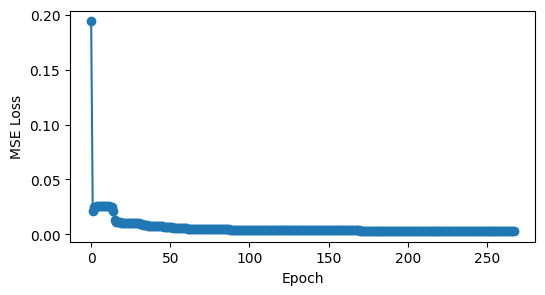

In [19]:
plt.figure(figsize=(6,3))
plt.plot(history,marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

## Inference & AUC

In [21]:
# Load best model for inference
checkpoint = torch.load('best_model.pt', map_location=DEVICE)
model = MLP_AE().to(DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Inference and evaluation
scores, labels = [], []
with torch.no_grad():
    for x, y in tqdm(test_dl, desc='Test'):  # evaluation
        x = x.to(DEVICE)
        recon = model(x)
        err = ((x - recon) ** 2).mean(dim=1).cpu().numpy()
        scores.extend(err)
        labels.extend(y.numpy())

auc = roc_auc_score(labels, scores)
print(f"Test AUC: {auc:.4f}")


Test: 100%|██████████| 3/3 [00:00<00:00, 10.00it/s]

Test AUC: 0.9126


## Error Distribution

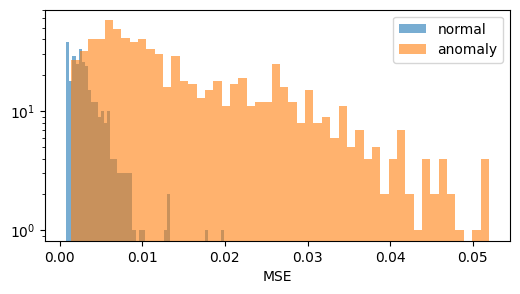

In [22]:
norm=[s for s,l in zip(scores,labels) if l==0]
anom=[s for s,l in zip(scores,labels) if l==1]
plt.figure(figsize=(6,3))
plt.hist(norm,bins=50,alpha=0.6,label='normal',log=True)
plt.hist(anom,bins=50,alpha=0.6,label='anomaly',log=True)
plt.xlabel('MSE')
plt.legend()
plt.show()